# CRD Extinction Calculations

The following discussion and code demonstrates how the data acquisition software calculates various values that are part of the data output.  This discussion includes some Python code that can be used to process this code.  Calculations are demonstrated using data recovered from the open path cavity ringdown during the FRAPE campaign.   

In [36]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib
from math import *
import numpy as np
import pandas as pd
%matplotlib inline

In [37]:
# Define some constants for use in the equations below
A = 6.0225e23 # Angstrom exponent
R = 8.31447 # Ideal gas constant
c = 2.99792e8 # Speed of light in m/s

# Calculating the Refactive Index

The refractive index of gas is dependent only on the wavelength of the light 𝜆 and is calculated based on <a href='http://www.opticsinfobase.org/ao/abstract.cfm?uri=ao-34-15-2765'>Bucholtz (1995)</a>. With the wavelength in nm, the refractive index may be calculated as 
\begin{equation}
n = \left(\frac{5791817}{238.0185-\left(\frac{1000}{\lambda}\right)^2}+\frac{167909}{57.362-\left(\frac{1000}{\lambda}\right)^2}\right)\times{10}^{-8}+1
\end{equation}

In [38]:
'''
The following defines the function for returning the refractive index of air.  Here, the wavelength is in nm.
'''
def ref_index(l):
    if l > 230:
        return (5791817/(238.0185-(1000/l)**2)+167909/(57.362-(1000/l)**2))*10**-8+1
    else:
        return (2480990/(132.274-(1000/l)**2)+17455.7/(39.32957-(1000/l)**2)+8060.51)*10**-8+1

In [39]:
y = []
for i in range(400,700):
    y.append(ref_index(float(i)))
    
x = list(range(400,700))

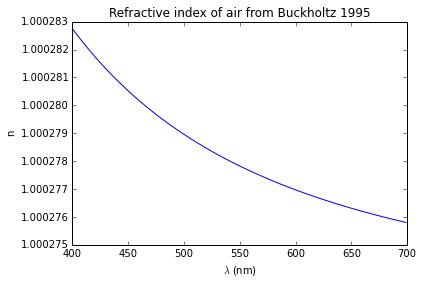

In [40]:
# This plots refractive index from 400 to 700 nm
fig = plt.figure()
ax = plt.axes()
plt.ylabel('n')
plt.xlabel(r'$\lambda$ (nm)')
plt.title('Refractive index of air from Buckholtz 1995')
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter(useOffset=False))
plt.plot(x, y)

## Scattering Coefficient

From <a href='http://www.opticsinfobase.org/ao/abstract.cfm?uri=ao-34-15-2765'>Bucholtz (1995)</a>, the scattering cross section $\sigma_{air}$ is calculated as 
\begin{equation}
\sigma_{air}=\frac{24\pi^3\left(n^2-1\right)^2}{\lambda^4M_{ref}^2\left(n^2+2\right)^2}f\left(\delta\right)
\end{equation}
where $n$ is the real portion of the refractive index as calculated above and $f(\delta)$ is the factor that accounts for the anisotropy of air and may be approximated as 1.06.

In [41]:
# Calculate the scattering coefficient
Mref = 2.50362e25

def cext(l):
    """
    Calculate the scattering cross section of air as a function of ambient conditions and the wavelength of light
    :l: wavelength of light in nm
    """
    l = float(l)
    return 24.*pi**3*((ref_index(l)**2-1.)/(ref_index(l)+2.))**2/((l/1.e7)**4*(Mref/1e6)**2)*1.06

In [42]:
z = [cext(i) for i in range(400,700)]
    
x = list(range(400,700))

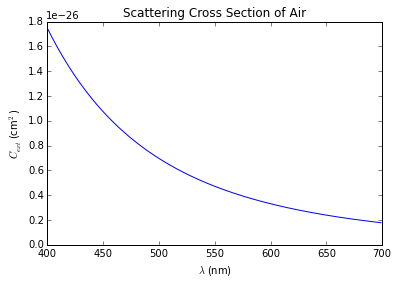

In [43]:
fig = plt.figure()
ax = plt.axes()
plt.ylabel(r'$C_{ext}$ (cm$^2$)')
plt.xlabel(r'$\lambda$ (nm)')
plt.title('Scattering Cross Section of Air')
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter(useOffset=False))
plt.plot(x, z)

## Accounting for Rayleigh Scattering

Now for the final demonstration, we want to demonstrate the correction of $\tau$ for Rayleigh and the resulting extinction calculations.  $\tau$ may be corrected using the following equation:
\begin{equation}
\tau' = [\frac{1}{\tau}-\sigma_{air}c(M-M_{ref})]
\end{equation}
Here, $M$ is a the molecular density and is a function of the ambient temperature $T$ and pressure $P$.  The molecular density can be solved for using the ideal gas equation:
\begin{equation}
M=\frac{p\unicode{x212B}}{RT}
\end{equation}
where $R$ is the ideal gas constant of 8.31447 J/(mol K) and $\unicode{x212B}$ is the angstrom exponent ($6.0225\times10^{23}$ molecules per mole).

In [44]:
def mol_den(P,T):
    """
    :P: pressure in mb
    :T: temperature in deg C
    """
    # Convert from mb to Pa
    P = P*100
    # Convert to Kelvin
    T = T + 273.15
    return P*A/(R*T)

In [45]:
def tau_corr(tau, l, T, P):
    """
    Correct tau for Rayleigh scattering.
    tau: Ringdown time constant
    l: wavelength in nm
    T: temperature in deg C
    P: pressure in mb
    """
    return 1/(1/tau -cext(l)/100**2*(mol_den(P,T) - Mref)*c)

In [46]:
def ext(tau,tau0,L):
    """
    Calculate extinction.
    :tau: current ringdown time constant in seconds
    :tau0: filtered ringdown time constant in seconds
    :L: optical time constant in meters
    """
    return (1/tau - 1/tau0)*L/c

In [47]:
print(mol_den(840,20)*cext(532));

0.11216825937399315


Now we will demonstrate how to use the above functions with data from acquired from the data acquisition system.  First, we retrieve data from the file using the <a href='http://pandas.pydata.org/'>pandas</a> library.

In [48]:
# Get some data
fData = "C:\Users\mrichardson\Desktop\Tim_20140731_140955.txt"
# Read in data via Pandas (creates a Pandas object)
df = pd.read_csv(fData, delimiter = '\t')

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-48-2d48519056a0>, line 2)

Next, generate a series of plots comparing calculated values with those recovered from the field

In [ ]:
fig1 = plt.figure(1)
plt.subplot(221)
# Optical length of cavity
Rl = 1
# Time stamp is in hours
time = (df.time_stamp-df.time_stamp[0])/3600
# Calculate extinction
ext_calc = ext(df.tau*1e-6,df.tau_0*1e-6, Rl)
plt.plot(time, df.ext, 'r-',time, ext_calc*1e6,'b-')
plt.ylim(0,40)
plt.ylabel(r'$\sigma$ (Mm$^-1$)')

plt.subplot(222)
plt.plot(time,df.tau_corr,'r-',time,tau_corr(df.tau*1e-6,670.0,df.T_vaisala,df.pressure)*1e6,'b-')
plt.ylabel(r'$\tau_{corr}$ ($\mu$s)')

plt.subplot(224)
plt.plot(time,df.tau_0_corr,'r-',time,tau_corr(df.tau_0*1e-6,670.0,df.T_vaisala,df.pressure)*1e6,'b-')
plt.ylabel(r'$\tau_{0,corr}$ ($\mu$s)')

plt.subplot(223)
# Extinction from corrected values in file
plt.ylabel(r'$\sigma_{corr}$ (Mm$^{-1}$)')
plt.plot(time,df.ext_corr*1e6,'r-',time,ext(tau_corr(df.tau*1e-6,670,df.T_vaisala,df.pressure), \
                                            tau_corr(df.tau_0*1e-6,670.0,df.T_vaisala,df.pressure), 1),'b-')